In [ ]:
!pip install pydub

In [ ]:
# PREP DATAFRAMES

import pandas as pd
import torch
import torchaudio
import torchaudio.transforms as T
import torchvision
import torchvision.transforms as transforms
from pydub import AudioSegment
import os
import matplotlib.pyplot as plt
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

mp3_path = '/content/drive/MyDrive/AudioML/mp3Files/'
wav_path = '/content/drive/MyDrive/AudioML/smolWavFiles/'
smol_wav_path = '/content/drive/MyDrive/AudioML/smolWavFiles/'
csv_file_path = '/content/drive/MyDrive/AudioML/songLabels.csv'
spectrogram_path = '/content/drive/MyDrive/AudioML/spectrograms/'
trimmed_spectoram_path = '/content/drive/MyDrive/AudioML/trimmedSpectrograms/'

songDF = pd.read_csv(csv_file_path)
print("song dataframe:\n", songDF)

Mounted at /content/drive
song dataframe:
         Armin van Buuren - Lose This Feeling      drum and bass    150
0                               Bicep - Glue        electronica  130.0
1                  Chase & Status - Baddadan      drum and bass  176.0
2       Chase & Status - Liquor & Cigarettes      drum and bass    NaN
3     Daryl Hall & John Oates - Out of Touch        indie dance    NaN
4                   Deadmau5 - Faxing Berlin  progressive house  128.0
5                  Dimension - DJ Turn It Up           hardcore  130.0
6  Fred again.. - Marea (we’ve lost dancing)         deep house  123.0
7                        Hi-Lo - RIDE OR DIE             Techno    NaN


In [ ]:
# MAKE WAV SEGMENTS FROM MP3

def extract_loudest_segments(mp3_path, smol_wav_path, duration=5 ):
    os.makedirs(smol_wav_path, exist_ok=True)

    for root, _, files in os.walk(mp3_path):
        mp3_files = [f for f in files if f.endswith('.mp3')]
        for mp3_file in mp3_files:
            mp3_file_path = os.path.join(root, mp3_file)
            audio = AudioSegment.from_mp3(mp3_file_path)

            loudest_start = 0
            loudest_end = duration * 1000
            loudest_lufs = float('-inf')

            for start in range(0, len(audio) - duration * 1000, 1000):
                end = start + duration * 1000
                segment = audio[start:end]

                lufs = segment.dBFS

                if lufs > loudest_lufs:
                    loudest_start = start
                    loudest_end = end
                    loudest_lufs = lufs
            print(loudest_lufs, "LUFS over", duration, "seconds")

            loudest_segment = audio[loudest_start:loudest_end]
            output_file = os.path.join(smol_wav_path, os.path.splitext(mp3_file)[0] + '_loudest.wav')
            loudest_segment.export(output_file, format="wav")

            print(f"{mp3_file_path} - DONE")

    print("\nFinished extracting loudest segments\n")

extract_loudest_segments(mp3_path, smol_wav_path) #

-8.202201903088632 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/CamelPhat - Breathe.mp3 - DONE
-6.185438748794413 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Dimension - DJ Turn It Up.mp3 - DONE
-10.108939216653162 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Daryl Hall & John Oates - Out of Touch.mp3 - DONE
-4.725245130551406 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Chase & Status - Baddadan.mp3 - DONE
-8.503132072992155 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Maddix - My Gasoline.mp3 - DONE
-6.425929975892382 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Hi-Lo - RIDE OR DIE.mp3 - DONE
-10.575355103604245 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Bicep - Glue.mp3 - DONE
-6.257597777244684 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Overmono - Blow Out.mp3 - DONE
-5.023979055454966 LUFS over 5 seconds
/content/drive/MyDrive/AudioML/mp3Files/Chase & Status

In [ ]:
smol_wav_path

'/content/drive/MyDrive/AudioML/smolWavFiles/'

/usr/local/lib/python3.10/dist-packages/torchaudio/functional/functional.py:584: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


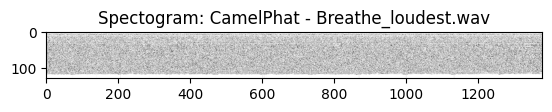

CamelPhat - Breathe_loudest.wav  -  DONE


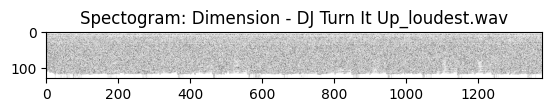

Dimension - DJ Turn It Up_loudest.wav  -  DONE


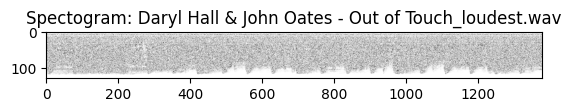

Daryl Hall & John Oates - Out of Touch_loudest.wav  -  DONE


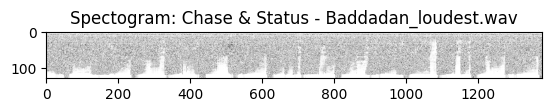

Chase & Status - Baddadan_loudest.wav  -  DONE


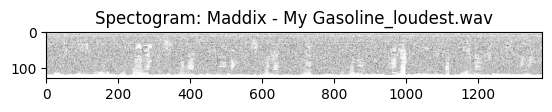

Maddix - My Gasoline_loudest.wav  -  DONE


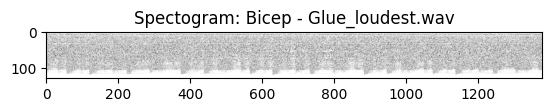

Bicep - Glue_loudest.wav  -  DONE


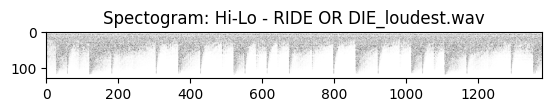

Hi-Lo - RIDE OR DIE_loudest.wav  -  DONE


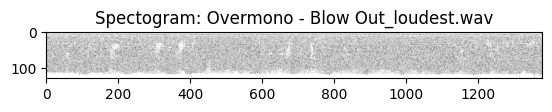

Overmono - Blow Out_loudest.wav  -  DONE


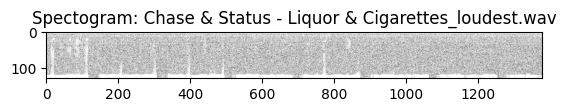

Chase & Status - Liquor & Cigarettes_loudest.wav  -  DONE


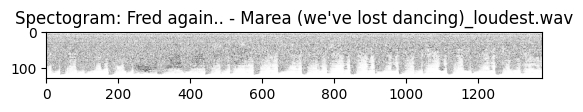

Fred again.. - Marea (we've lost dancing)_loudest.wav  -  DONE


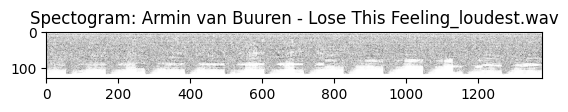

Armin van Buuren - Lose This Feeling_loudest.wav  -  DONE


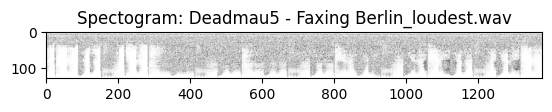

Deadmau5 - Faxing Berlin_loudest.wav  -  DONE


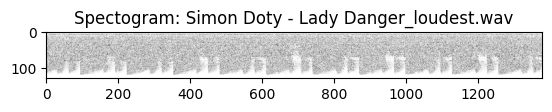

Simon Doty - Lady Danger_loudest.wav  -  DONE


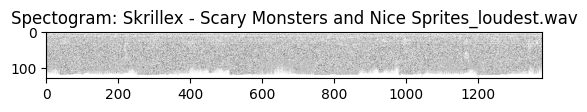

Skrillex - Scary Monsters and Nice Sprites_loudest.wav  -  DONE


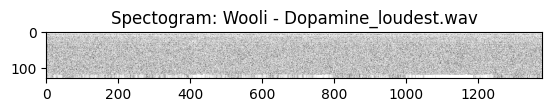

Wooli - Dopamine_loudest.wav  -  DONE

Finished converting mp3 to cropped mel spectrograms



In [ ]:
# CONVERT WAV TO MEL SPECTOGRAM

# consolidated wav files and spectograms, using 30x less storage
def convert_wav_to_mel_spectrogram(wav_folder, spectrogram_folder, sample_rate=44100, n_fft=400, win_length=400, hop_length=160, n_mels=128):
    os.makedirs(spectrogram_folder, exist_ok=True)

    wav_files = [f for f in os.listdir(wav_folder) if f.endswith('.wav')]

    mel_spec_transform = T.MelSpectrogram(
        sample_rate=sample_rate,
        n_fft=n_fft,
        win_length=win_length,
        hop_length=hop_length,
        n_mels=n_mels
    )

    for wav_file in wav_files:
        wav_path = os.path.join(wav_folder, wav_file)
        waveform, sample_rate = torchaudio.load(wav_path, num_frames=-1)

        mel_spectrogram = mel_spec_transform(waveform)
        mel_spectrogram = transforms.ToPILImage()(mel_spectrogram)

        spec_file = os.path.join(spectrogram_folder, os.path.splitext(wav_file)[0] + '.png')
        mel_spectrogram.save(spec_file)
        plt.imshow(mel_spectrogram)
        plt.title(f"Spectogram: {wav_file}")
        plt.show()

        print(wav_file, " -  DONE")

    print("\nFinished converting mp3 to cropped mel spectrograms\n")

convert_wav_to_mel_spectrogram(smol_wav_path, spectrogram_path)
#delete_wavs(wav_path)


In [ ]:
import pandas as pd
import os

# Paths to the directories
spectrogram_path = '/content/drive/MyDrive/AudioML/spectrograms/'
csv_file_path = '/content/drive/MyDrive/AudioML/songLabels.csv'

# Create an empty list to store the data
data = []

# Load CSV data
songDF = pd.read_csv(csv_file_path)

# Iterate over the spectrogram files and corresponding CSV data
for root, _, files in os.walk(spectrogram_path):
    spectrogram_files = [f for f in files if f.endswith('.png')]
    for spec_file in spectrogram_files:
        spec_file_path = os.path.join(root, spec_file)
        # Extract song name from the spectrogram filename
        song_name = os.path.splitext(spec_file)[0]
        # Find the corresponding row in the CSV data
        csv_row = songDF[songDF['song_name'] == song_name]

        # Check if a matching CSV row is found
        if not csv_row.empty:
            genre = csv_row.iloc[0]['genre']
            bpm = csv_row.iloc[0]['bpm']
            data.append({'song_name': song_name, 'genre': genre, 'bpm': bpm, 'spectrogram_path': spec_file_path})

# Create a DataFrame from the collected data
df = pd.DataFrame(data)

# Display the DataFrame
print("DataFrame:\n", df)


KeyError: ignored

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:01<00:00, 96461309.52it/s] 


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


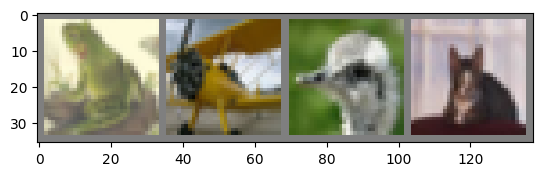

frog  plane bird  cat  


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# import and define neural network

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Net()

In [ ]:
import torch.optim as optim

# import and define optimizer / loss function

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [ ]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

print('Finished Training')

[1,  2000] loss: 2.202
[1,  4000] loss: 1.871
[1,  6000] loss: 1.710
[1,  8000] loss: 1.580
[1, 10000] loss: 1.525
[1, 12000] loss: 1.473
[2,  2000] loss: 1.434
[2,  4000] loss: 1.381
[2,  6000] loss: 1.353
[2,  8000] loss: 1.332
[2, 10000] loss: 1.308
[2, 12000] loss: 1.295
Finished Training


In [ ]:
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

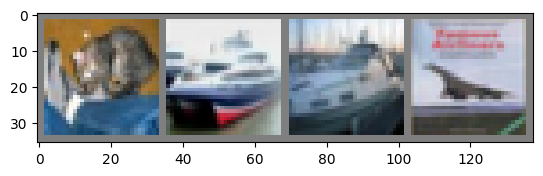

GroundTruth:  cat   ship  ship  plane


In [ ]:
dataiter = iter(testloader)
images, labels = next(dataiter)

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))

In [ ]:
net = Net()
net.load_state_dict(torch.load(PATH)) # reload model of necessary

<All keys matched successfully>

In [ ]:
outputs = net(images)

In [ ]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

Predicted:  cat   dog   car   horse


In [ ]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy of the network on the 10000 test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 53 %


In [ ]:
# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f'Accuracy for class: {classname:5s} is {accuracy:.1f} %')

NameError: ignored